In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm
from transformers import BertModel, BertTokenizer

/home/cc/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def preprocess(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    parsed_text = parsed_text.replace("\t", "")
    parsed_text = parsed_text.replace("!", "")
    parsed_text = parsed_text.replace(" RT : ", "")
    parsed_text = parsed_text.replace("RT ", "")
    parsed_text = parsed_text.strip()
    return parsed_text


dataset_path = "./hate-speech-and-offensive-language/data/labeled_data.csv"
all_df = pd.read_csv(dataset_path)
for label in ["Unnamed: 0", "count", "hate_speech", "offensive_language", "neither"]:
    del all_df[label]
all_df.tweet = all_df.tweet.apply(preprocess)
all_df = all_df.sample(frac=1).reset_index(drop=True)

print(all_df.head())

train_limit = int(len(all_df) * 0.8)
train_df, test_df = all_df[:train_limit], all_df[train_limit:]

#train_df = train_df[:1000]
#test_df = test_df[:1000]

   class                                              tweet
0      1  &#8220;: LMAOOO I find this shit so funny y'al...
1      1  This bitch compared dicks to pencils get sharp...
2      1  : 'You'd rather live with trash,, than make it...
3      1   whats good then bitch Ass nigga catch your phase
4      1  Gresham Road Soldier BoulderCrest Soldier and ...


In [11]:
class Model(nn.Module):
    def __init__(self, dropout=0.5):
        super(Model, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased', torchscript=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, x = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.relu(x)
        return x


model = Model()
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', torchscript=True)

vocab_file = open("bert_cased_vocab.txt", "w")
for i, j in tokenizer.get_vocab().items():
    vocab_file.write(f"{i} {j}\n")
vocab_file.close()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]

        text = tokenizer(sample.tweet, padding='max_length', max_length = 32, truncation=True, return_tensors="pt")
        label = sample["class"]

        return text, label


train_dataset = Dataset(train_df)
test_dataset = Dataset(test_df)

datasets = dict()
datasets["train"] = train_dataset
datasets["test"] = test_dataset

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

dataloaders = dict()
dataloaders["train"] = train_dataloader
dataloaders["test"] = test_dataloader

In [17]:
device = torch.device("cpu")

model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-6)

In [18]:
epochs = 1

losses = {"train": [], "test": []}
accuracies = {"train": [], "test": []}

for epoch_num in range(epochs):
    for phase in ["train", "test"]:

        if phase == "train":
            model.train()
        else:
            model.eval()

        total_loss, total_acc = 0, 0
        for batch_input, batch_label in tqdm(dataloaders[phase], desc=phase):
            batch_label = batch_label.to(device)
            batch_attention_mask = batch_input['attention_mask'].to(device)
            batch_input_ids = batch_input['input_ids'].squeeze(1).to(device)

            output = model(batch_input_ids, batch_attention_mask)
        
            batch_loss = criterion(output, batch_label.long())
            total_loss += batch_loss.item()
            total_acc += (output.argmax(dim=1) == batch_label).sum().item()

            if phase == "train":
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
        
        losses[phase].append(total_loss / len(datasets[phase]))
        accuracies[phase].append(total_acc / len(datasets[phase]))

    print(losses)
    print(accuracies)

test: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s]


{'train': [0.03845706218033413], 'test': [0.006317730828449325]}
{'train': [0.7688388984162211], 'test': [0.8638289287875731]}


test: 100%|██████████| 78/78 [00:28<00:00,  2.76it/s]


{'train': [0.03845706218033413, 0.02499850144806915], 'test': [0.006317730828449325, 0.005404375341719188]}
{'train': [0.7688388984162211, 0.8659336225158882], 'test': [0.8638289287875731, 0.8908614081097438]}


test: 100%|██████████| 78/78 [00:28<00:00,  2.74it/s]


{'train': [0.03845706218033413, 0.02499850144806915, 0.021727567032606393], 'test': [0.006317730828449325, 0.005404375341719188, 0.00486207009413946]}
{'train': [0.7688388984162211, 0.8659336225158882, 0.8899424997478059], 'test': [0.8638289287875731, 0.8908614081097438, 0.8957030461972968]}


test: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


{'train': [0.03845706218033413, 0.02499850144806915, 0.021727567032606393, 0.019281102974795676], 'test': [0.006317730828449325, 0.005404375341719188, 0.00486207009413946, 0.00457659920022592]}
{'train': [0.7688388984162211, 0.8659336225158882, 0.8899424997478059, 0.8983657823060628], 'test': [0.8638289287875731, 0.8908614081097438, 0.8957030461972968, 0.8967117207988703]}


test: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]

{'train': [0.03845706218033413, 0.02499850144806915, 0.021727567032606393, 0.019281102974795676, 0.018046452941835787], 'test': [0.006317730828449325, 0.005404375341719188, 0.00486207009413946, 0.00457659920022592, 0.0044428449795206205]}
{'train': [0.7688388984162211, 0.8659336225158882, 0.8899424997478059, 0.8983657823060628, 0.9041662463431858], 'test': [0.8638289287875731, 0.8908614081097438, 0.8957030461972968, 0.8967117207988703, 0.896913455719185]}


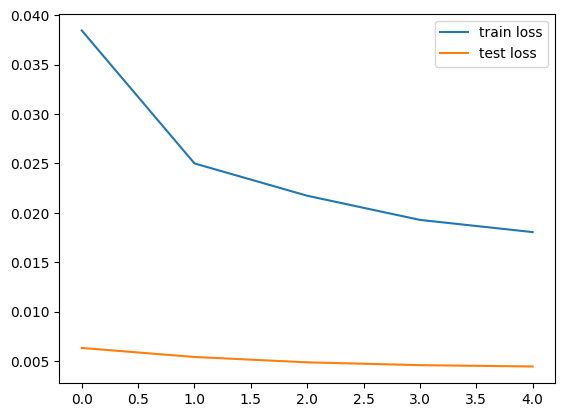

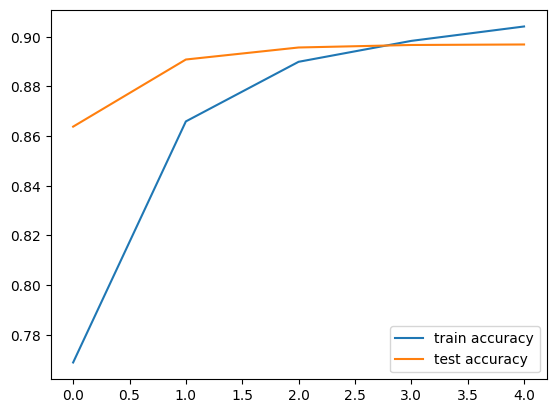

In [23]:
plt.plot(range(epochs), losses["train"], label="train loss")
plt.plot(range(epochs), losses["test"], label="test loss")
plt.legend()
plt.show()

plt.plot(range(epochs), accuracies["train"], label="train accuracy")
plt.plot(range(epochs), accuracies["test"], label="test accuracy")
plt.legend()
plt.show()

In [24]:
model.eval()
model = model.to("cpu")

sample_input_id, sample_label = next(iter(test_dataloader))

sample_label = sample_label.to("cpu")
sample_mask = sample_input_id['attention_mask'].to("cpu")
sample_input_id = sample_input_id['input_ids'].squeeze(1).to("cpu")

traced_script_module = torch.jit.trace(model.cpu(), [sample_input_id, sample_mask])
traced_script_module.save("traced_text_classification_model.pt")

In [25]:
example = "Moreno be a little bitch . You dumb bitch ."

tokenizer_out = tokenizer(example, padding='max_length', max_length = 32, truncation=True, return_tensors="pt")
input_ids = tokenizer_out["input_ids"]
attention_mask = tokenizer_out["attention_mask"]

preds = model(input_ids, attention_mask)

In [26]:
preds

tensor([[1.5776, 5.3970, 0.0000]], grad_fn=<ReluBackward0>)